In [73]:
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from utils import print_confusion_matrix
from ISLP import load_data

# Stock Market Dataset

Here, we are trying to predict the direction of the movement of the stock market based on the percentage returns of the past 5 days, the volume, and today's percentage change.

In [2]:
Smarket = load_data("Smarket")
Smarket.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up


In [3]:
Smarket.select_dtypes(include="number").corr()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,0.029700,0.030596,0.033195,0.035689,0.029788,0.539006,0.030095
Lag1,0.029700,1.000000,-0.026294,-0.010803,-0.002986,-0.005675,0.040910,-0.026155
Lag2,0.030596,-0.026294,1.000000,-0.025897,-0.010854,-0.003558,-0.043383,-0.010250
Lag3,0.033195,-0.010803,-0.025897,1.000000,-0.024051,-0.018808,-0.041824,-0.002448
Lag4,0.035689,-0.002986,-0.010854,-0.024051,1.000000,-0.027084,-0.048414,-0.006900
Lag5,0.029788,-0.005675,-0.003558,-0.018808,-0.027084,1.000000,-0.022002,-0.034860
Volume,0.539006,0.040910,-0.043383,-0.041824,-0.048414,-0.022002,1.000000,0.014592
Today,0.030095,-0.026155,-0.010250,-0.002448,-0.006900,-0.034860,0.014592,1.000000


<Axes: >

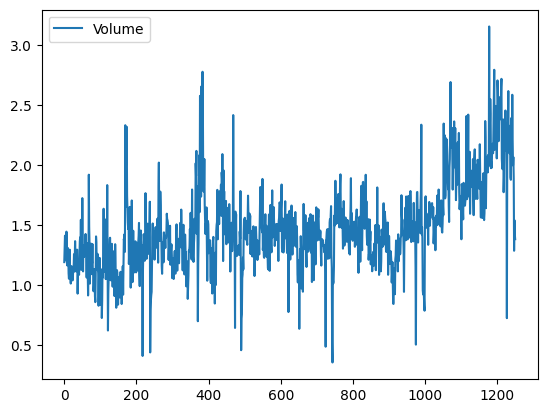

In [4]:
Smarket.plot(y="Volume")

## Logistic Regression

In [5]:
X = Smarket.drop(columns=["Today", "Direction", "Year"])
X = sm.add_constant(X)
y = Smarket["Direction"] == "Up"

glm = sm.GLM(y, X, family=sm.families.Binomial())
results = glm.fit()
print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Direction   No. Observations:                 1250
Model:                            GLM   Df Residuals:                     1243
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -863.79
Date:                Sun, 01 Dec 2024   Deviance:                       1727.6
Time:                        12:12:00   Pearson chi2:                 1.25e+03
No. Iterations:                     4   Pseudo R-squ. (CS):           0.002868
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1260      0.241     -0.523      0.6

There is no clear association between the Lag variables and the direction, even though Lag1 has the smallest p-value out of all the other variables. 

In [6]:
probabilities = results.predict()
probabilities[:10]

array([0.50708413, 0.48146788, 0.48113883, 0.51522236, 0.51078116,
       0.50695646, 0.49265087, 0.50922916, 0.51761353, 0.48883778])

In [7]:
labels = np.array(["Down"] * len(X))
labels[probabilities > 0.5] = "Up"

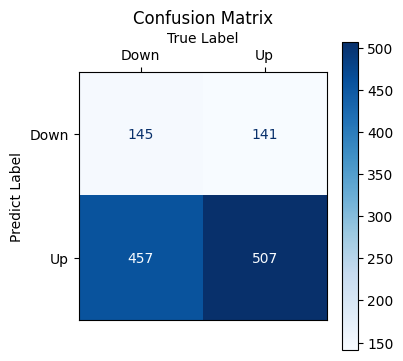

In [8]:
cm = print_confusion_matrix(Smarket.Direction, labels)

In [9]:
# Average training accuracy and error rate
training_acc = (145 + 507) / cm.sum()
training_err = 1 - training_acc

training_acc, training_err

(0.5216, 0.47840000000000005)

Instead of using the whole dataset for training, we split it

In [10]:
train_mask = (Smarket["Year"] < 2005)
train = Smarket.loc[train_mask]
test = Smarket.loc[~train_mask]
train.shape, test.shape

((998, 9), (252, 9))

In [11]:
X_train, y_train = X.loc[train_mask], y.loc[train_mask]
X_test, y_test = X.loc[~train_mask], y.loc[~train_mask]
glm = sm.GLM(y_train, X_train, family=sm.families.Binomial())

results = glm.fit()
print(results.summary())

probabilities = results.predict(exog=X_test)

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Direction   No. Observations:                  998
Model:                            GLM   Df Residuals:                      991
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -690.55
Date:                Sun, 01 Dec 2024   Deviance:                       1381.1
Time:                        12:12:01   Pearson chi2:                     998.
No. Iterations:                     4   Pseudo R-squ. (CS):           0.002162
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1912      0.334      0.573      0.5

In [12]:
labels_train, labels_test = Smarket.Direction.loc[train_mask], Smarket.Direction.loc[~train_mask]

In [13]:
labels_pred = np.array(["Down"] * len(X_test))
labels_pred[probabilities > 0.5] = "Up"

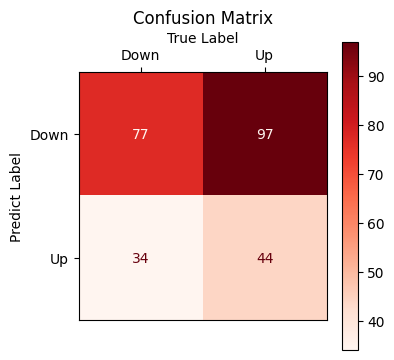

In [14]:
cm = print_confusion_matrix(labels_test, labels_pred, cmap="Reds")

In [15]:
# Test accuracy and error rates
np.mean(labels_pred == labels_test), np.mean(labels_pred != labels_test)

(0.4801587301587302, 0.5198412698412699)

Let us only use Lag1 and Lag2 now since they have the smallest p-values out of all the variables

In [16]:
X = Smarket.loc[:, ["Lag1", "Lag2"]]
X = sm.add_constant(X)
X_train, X_test = X.loc[train_mask], X.loc[~train_mask]

glm = sm.GLM(y_train, X_train, family=sm.families.Binomial())

results = glm.fit()
print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Direction   No. Observations:                  998
Model:                            GLM   Df Residuals:                      995
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -690.70
Date:                Sun, 01 Dec 2024   Deviance:                       1381.4
Time:                        12:12:01   Pearson chi2:                     998.
No. Iterations:                     4   Pseudo R-squ. (CS):           0.001865
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0322      0.063      0.508      0.6

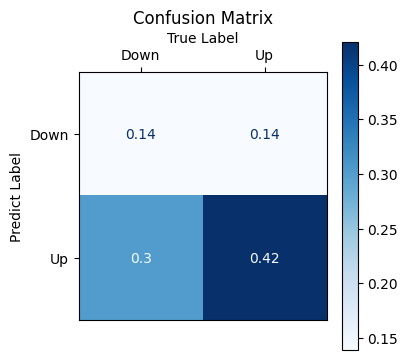

In [17]:
probabilities = results.predict(exog=X_test)
labels_pred = np.array(["Down"] * len(X_test))
labels_pred[probabilities > 0.5] = "Up"

cm = print_confusion_matrix(labels_test, labels_pred, normalize="all")

In [18]:
# Test accuracy and precision
print("Accuracy:", cm[0, 0] + cm[1, 1])
print("Precision:", cm[1, 1]/(cm[1, 0] + cm[1, 1]))

Accuracy: 0.5595238095238095
Precision: 0.5824175824175825


The logistic regression model is not much better than random guessing, but has a decent precision. So, one strategy can be to trade when the model predicts that the market will move up, and to not trade when it predicts a decrease.

## Linear Discriminant Analysis

In [19]:
lda = LDA(store_covariance=True)

In [20]:
X = Smarket.loc[:, ["Lag1", "Lag2"]]
X_train, X_test = X.loc[train_mask], X.loc[~train_mask]
y = Smarket.Direction
y_train, y_test = y.loc[train_mask], y.loc[~train_mask]

lda.fit(X_train, y_train)

LinearDiscriminantAnalysis(store_covariance=True)

In [21]:
lda.classes_

array(['Down', 'Up'], dtype='<U4')

In [22]:
lda.means_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

The previous two days' returns have a tendency to be negative when the market goes up, and positive when the market goes down. 

In [23]:
# Prior probabilities of the classes
lda.priors_

array([0.49198397, 0.50801603])

In [24]:
lda.scalings_

array([[-0.64201904],
       [-0.51352928]])

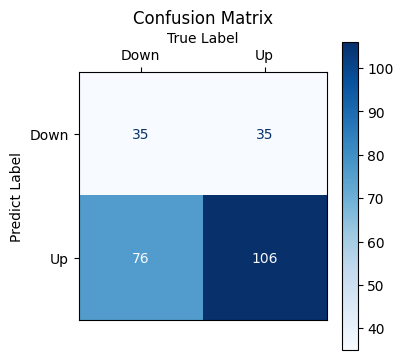

In [25]:
y_pred = lda.predict(X_test)
cm = print_confusion_matrix(y_test, y_pred)

## Quadratic Discriminant Analysis

In [26]:
qda = QDA(store_covariance=True)

In [27]:
qda.fit(X_train, y_train)

QuadraticDiscriminantAnalysis(store_covariance=True)

In [28]:
qda.means_, qda.priors_

(array([[ 0.04279022,  0.03389409],
        [-0.03954635, -0.03132544]]),
 array([0.49198397, 0.50801603]))

In [29]:
qda.covariance_

[array([[ 1.50662277, -0.03924806],
        [-0.03924806,  1.53559498]]),
 array([[ 1.51700576, -0.02787349],
        [-0.02787349,  1.49026815]])]

In [30]:
qda.scalings_

[array([1.56294495, 1.47927279]), array([1.53455065, 1.47272326])]

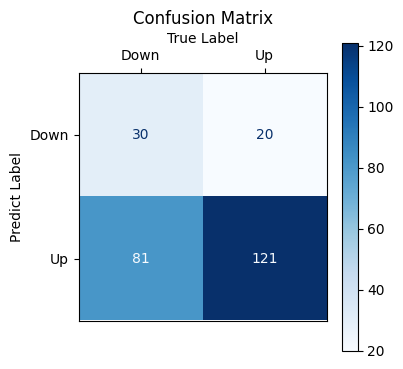

In [31]:
y_pred = qda.predict(X_test)
cm = print_confusion_matrix(y_test, y_pred) #, normalize="all")

In [32]:
print("Accuracy:", cm[0, 0] + cm[1, 1])
print("Precision:", cm[1, 1] / (cm[1, 0] + cm[1, 1]))

Accuracy: 151
Precision: 0.599009900990099


QDA is able to provide a much better accuracy and precision for this dataset

## Naive Bayes

In [33]:
naive_bayes = GaussianNB()
naive_bayes.fit(X_train, y_train)

GaussianNB()

In [34]:
naive_bayes.classes_, naive_bayes.class_prior_, naive_bayes.class_count_

(array(['Down', 'Up'], dtype='<U4'),
 array([0.49198397, 0.50801603]),
 array([491., 507.]))

In [35]:
naive_bayes.theta_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [36]:
naive_bayes.var_

array([[1.50355429, 1.53246749],
       [1.51401364, 1.48732877]])

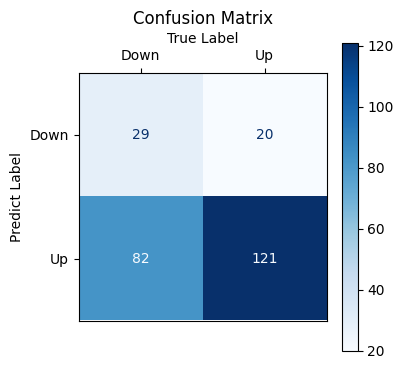

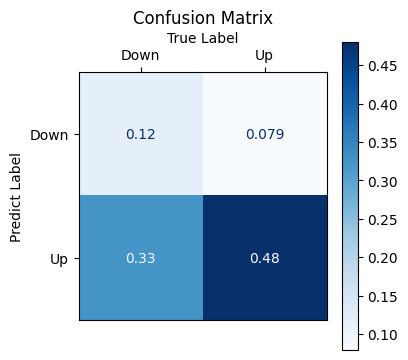

In [37]:
y_pred = naive_bayes.predict(X_test)
cm = print_confusion_matrix(y_test, y_pred)
cm2 = print_confusion_matrix(y_test, y_pred, normalize="all")

Naive Bayes performs better than LDA, and almost identical to QDA. 

## K-Neighbors Classifier

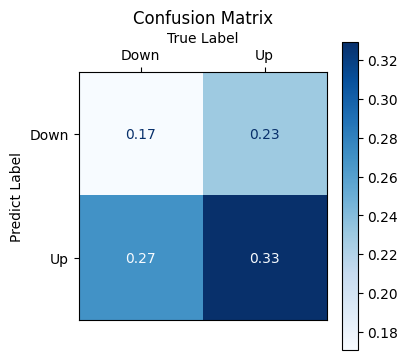

In [38]:
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(X_train, y_train)
knn1_pred = knn1.predict(X_test)
cm = print_confusion_matrix(y_test, knn1_pred, normalize="all")

# Caravan Dataset

Here, we are trying to predict whether a caravan owner purchases insurance or not.

In [40]:
Caravan = load_data("Caravan")
Caravan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 86 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   MOSTYPE   5822 non-null   int64   
 1   MAANTHUI  5822 non-null   int64   
 2   MGEMOMV   5822 non-null   int64   
 3   MGEMLEEF  5822 non-null   int64   
 4   MOSHOOFD  5822 non-null   int64   
 5   MGODRK    5822 non-null   int64   
 6   MGODPR    5822 non-null   int64   
 7   MGODOV    5822 non-null   int64   
 8   MGODGE    5822 non-null   int64   
 9   MRELGE    5822 non-null   int64   
 10  MRELSA    5822 non-null   int64   
 11  MRELOV    5822 non-null   int64   
 12  MFALLEEN  5822 non-null   int64   
 13  MFGEKIND  5822 non-null   int64   
 14  MFWEKIND  5822 non-null   int64   
 15  MOPLHOOG  5822 non-null   int64   
 16  MOPLMIDD  5822 non-null   int64   
 17  MOPLLAAG  5822 non-null   int64   
 18  MBERHOOG  5822 non-null   int64   
 19  MBERZELF  5822 non-null   int64   
 20  MBERBOER

In [42]:
Caravan["Purchase"].value_counts(normalize=True)

Purchase
No     0.940227
Yes    0.059773
Name: proportion, dtype: float64

In [44]:
X = Caravan.drop(columns=["Purchase"])
y = Caravan["Purchase"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1000, random_state=0)

In [45]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

## K-Neighbors Classifier

In [48]:
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(X_train_std, y_train)
knn1_pred = knn1.predict(X_test_std)

print(f"KNN Error Rate: {np.mean(knn1_pred != y_test)}")
print(f"Null Rate: {np.mean(y_test == 'Yes')}")

KNN Error Rate: 0.11
Null Rate: 0.067


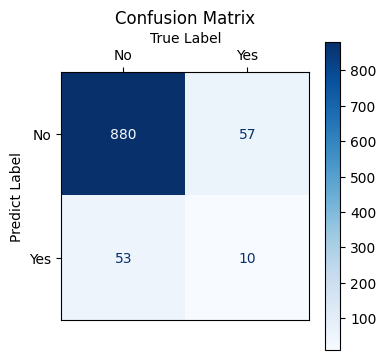

In [49]:
cm = print_confusion_matrix(y_test, knn1_pred)

In this case, we would like to maximize the precision - increasing the number of correct yes's relative to the total number of yes's. This will help target customers who would actually be likely to buy insurance.

In [54]:
print(f"Precision: {round(cm[1, 1]/cm[1].sum(), 4)}")

Precision: 0.1587


Let us tune the k-value for a better classifier

In [58]:
for k in range(1, 6):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train_std, y_train)
    pred = knn_model.predict(X_test_std)
    cm = confusion_matrix(y_test, pred).T

    tp = cm[1, 1]
    fp = cm[1, 0]
    precision = round((tp / (tp + fp)), 4)

    print(f"K: {k} | Predicted Yes: {tp + fp} | True Yes: {tp} | Precision: {precision}")

K: 1 | Predicted Yes: 63 | True Yes: 10 | Precision: 0.1587
K: 2 | Predicted Yes: 5 | True Yes: 0 | Precision: 0.0
K: 3 | Predicted Yes: 19 | True Yes: 3 | Precision: 0.1579
K: 4 | Predicted Yes: 4 | True Yes: 0 | Precision: 0.0
K: 5 | Predicted Yes: 6 | True Yes: 0 | Precision: 0.0


## Logistic Regression

Setting C to a very large value allows us to use the unregularized version of logistic regression

In [66]:
logreg = LogisticRegression(C=1e10, solver="liblinear")
logreg.fit(X_train_std, y_train)

LogisticRegression(C=10000000000.0, solver='liblinear')

In [70]:
pred_proba = logreg.predict_proba(X_test_std)
yes_pred_proba = pred_proba[:, 1]

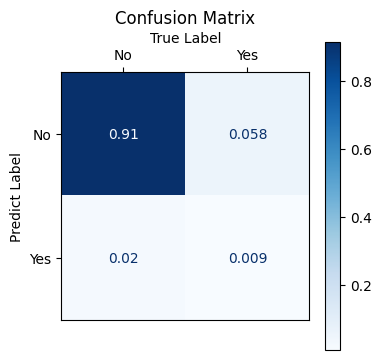

In [86]:
cm = print_confusion_matrix(
    y_test, 
    np.where(yes_pred_proba > 0.25, "Yes", "No"), 
    normalize="all"
)

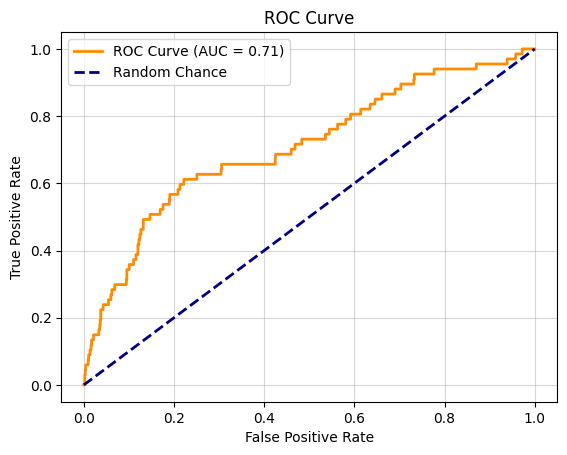

In [75]:
fpr, tpr, thresholds = roc_curve(y_test, yes_pred_proba, pos_label="Yes")
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, lw=2, color="darkorange", label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, ls="--", label="Random Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(alpha=0.5)
plt.show()
